# SNP filtering

SNPs were called genome-wide across 109 samples using `freebayes` <br>

I split the variant VCF into separate SNP and invariant VCFs using `bcftools` <br>
I'll only look at SNPs in this notebooks since that's what we're interested in. <br>

I have converted the SNP and Invariant VCFs to a Zarr databases using `vcf_to_zarr` from `scikit-allel` <br>
This is what I'll load and work with in this notebook

## Setup

### Import packages

In [2]:
import allel
import zarr

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

### Import SNP Zarr database

Zarr databases are made up of the following top-level structures:

 - `calldata`: Genotype annotations (i.e., FORMAT field in VCF)
 - `samples`: Sample IDs
 - `variants`: Site-specific annotations (e.g., INFO field in VCF)
 
Data are stored as `numpy` arrays for easy slicing, indexing, plotting, etc.

### Import SNPs and Invariant sites

**Note: Only looking at chromosome 3**

In [7]:
snp_zarr_path = '../../results/freebayes/zarr_db/CM019103.1/CM019103.1_allFinalSamples_snps.zarr/'
snp_callset = zarr.open_group(snp_zarr_path, mode='r')
invar_zarr_path = '../../results/freebayes/zarr_db/CM019103.1/CM019103.1_allFinalSamples_invariant.zarr/'
invar_callset = zarr.open_group(invar_zarr_path, mode='r')

## Functions

In [300]:
def extract_zarr_annotation(subdir, annot, zarr_db = snp_callset):
    """Extract site and genotype annotations from Zarr database by chromosome
    
    Args:
        chrom (str): Chromosome name as string
        subdir (str): Subdirectory for annotation. 'variants' for site-specific annotations
            (e.g., INFO field) or 'calldata' for genotype annotations (i.e., FORMAT field)
        annot (str): Annotation to extract (e.g., 'QUAL', 'ALT', 'DP')
        zarr_db (:obj: `zarr.hierarchy.Group`): Zarr database produced using `vcf_to_zarr`
            from `scikit-allel`
        
    Returns:
        zarr_array (:obj:`zarr.core.Array`): VCF annotation extracted as `numpy`
            array.
    """
    
    if subdir == 'samples':
        zarr_array = zarr_db['{0}'.format(subdir)]
    else:
        zarr_array = zarr_db['{0}/{1}'.format(subdir, annot)]
    
    return zarr_array


def subset_array(array, indices):
    """Little helper function to subset sites or samples by array of indices
    
    Args:
        array (:obj:`numpy.ndarray`): Array to be subset
        indices (:obj:`numpy.ndarray` of :obj:`int`): Array of integers representing
            the indices of variants passing QUAL filter.
    
    Returns:
        array_out (:obj:`numpy.ndarray`): Numpy array subsetting at indices
    """
    
    array_out = np.take(array, indices, axis=0)

    
    return array_out

def filter_missGT(gt_array, missing_gt_prop = 0.2):
    """Find indices of variants passing missing genotype filter
    
    Args:
        gt_array (:obj:`numpy.ndarray` of :obj:`list` of :obj:`int`): Numpy array with one list per 
            site and sample representing the two diploid alleles. Alleles can be 0 (REF), 1 (ALT), or -1 (Missing)
        missing_gt_prop (int): Threshold for missing genotypes. Variants with fewer than this proportion of
            missing genotype calls will be kept. 
        
    Returns:
        indices_to_keep (:obj:`numpy.ndarray` of :obj:`int`): Array of integers representing
            the indices of variants passing missing GT filter.
    """       
    total_sites = gt_array.n_variants
    num_samples = gt_array.n_samples
    
    missing_gt_boolArray = gt_array.is_missing()
    prop_missing_gt = missing_gt_boolArray.sum(axis = 1) / num_samples
    
    missGT_indicesToKeep = np.where(prop_missing_gt <= missing_gt_prop)[0]

    sites_passingGT = len(missGT_indicesToKeep)

    prop_passingGT = round((sites_passingGT / total_sites) * 100, 2)
    prop_toKeep = 1 - missing_gt_prop
    num_sample_threshold_toKeep = round(num_samples * prop_toKeep)
    print("{0}% ({1}) of sites have at least {2}% ({3}) of samples with genotype calls".format(prop_passingGT, sites_passingGT, prop_toKeep * 100, num_sample_threshold_toKeep))
    
    return missGT_indicesToKeep, prop_missing_gt
        
def plot_sfs(gt_array):
    ac = gt_array.count_alleles()
    sfs = allel.sfs_folded(gt_array.count_alleles())
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
    sns.barplot(x = [x for x in range(0, 110)], y = sfs.tolist(), color = "orange")
    plt.show()
    print(f'There are {ac.count_non_variant()} invariant sites, {ac.count_singleton()} singletons, and {ac.count_doubleton()} doubletons')

## Descriptive stats & raw SFS

In [301]:
gt_array_raw = extract_zarr_annotation(subdir = 'calldata', annot = 'GT')
pos_array_raw = extract_zarr_annotation(subdir = 'variants', annot = 'POS')[:]
gt_array_raw = allel.GenotypeArray(gt_array_raw)

In [302]:
print(f'There are {gt_array_raw.n_variants} SNPs genotyped across {gt_array_raw.n_samples} samples')

There are 4489811 SNPs genotyped across 109 samples


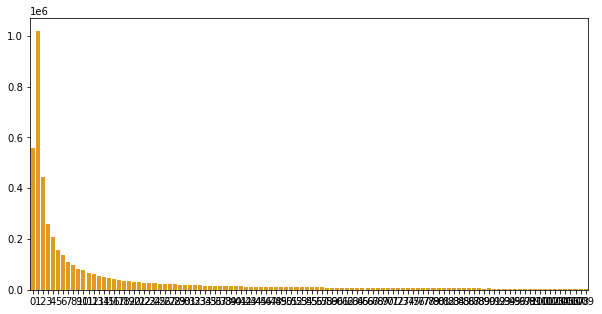

There are 543083 invariant sites, 1014938 singletons, and 439006 doubletons


In [303]:
plot_sfs(gt_array_raw)

## Filtering 

For filtering, I will loosly follow the suggestions made in [this tutorial](http://www.ddocent.com/filtering/) by
Jon Puritz, with some modifications. <br>
These suggested filtering criteria are similiar to those used
by [Julia Kreiner](https://github.com/jkreinz/Amaranthus-population-genomics/blob/master/snp_calling_filtering/filtering_vcfs.sh) in her recent paper.

For computational efficiency, I'm only filtering chromosome 3. This should provide a decent sense of how different filtering criteria will affect the data when applied genome-wide.

### Criteria 1: Missing genotype calls

Since genotype calls will be used to construct haplotypes for analyses (e.g., tests for positive selection), <br>
we want to make sure most samples have genotype calls. We will remove sites where most samples (e.g., >= 20%) are missing genotype calls.

**Important note: The manual for `selscan`, a program used for performing LD-based tests of selection <br>
based on extended haplotype homozygesity (EHH), specifically states: _Data must be phased and have no missing genotypes_ <br>
I haven't looked at missing data requirements of other programs but I imagine they're similar.**

Setting the filter below to 0% would result in no missing data. The resulting VCF can be phased with BEAGLE or SHAPEIT.

_Filter_: Prop missing genotype calls <= 0%

In [304]:
# Get array of SNP positions alongs chromosome 1
pos_vals = extract_zarr_annotation(subdir = 'variants', annot = 'POS')
pos_vals.shape

(4489811,)

In [305]:
pos_passingGTmissFilter, prop_GTmiss = filter_missGT(gt_array_raw, missing_gt_prop = 0)

28.97% (1300814) of sites have at least 100% (109) of samples with genotype calls


In [306]:
print(f'There are {gt_array_passGTmiss.n_variants} SNPs remaining after excluding sites with missing genotypes')

There are 1300814 SNPs remaining after excluding sites with missing genotypes


In [307]:
# Keep only positions that passed QUAL filter
positions_passGTmiss = np.take(pos_vals[:], pos_passingGTmissFilter, axis = 0)
positions_passGTmiss.shape

(1300814,)

In [308]:
gt_array_passGTmiss = subset_array(gt_array_raw, pos_passingGTmissFilter)

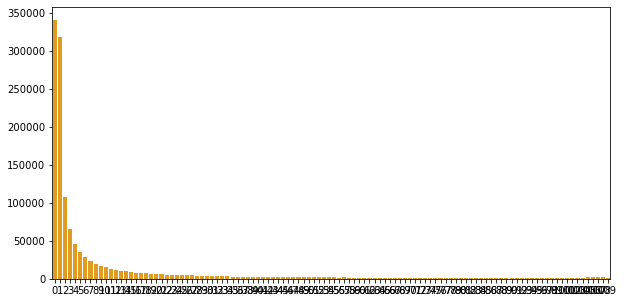

There are 339908 invariant sites, 317455 singletons, and 107535 doubletons


In [309]:
plot_sfs(gt_array_passGTmiss)

#### Generate variant table with annotations of interest

In [310]:
# Created sorted indext for later subsetting of Variant table
positions_index = allel.SortedIndex(positions_passGTmiss)
positions_index

0,1,2,3,4,...,1300809,1300810,1300811,1300812,1300813
13029,13036,13038,13043,13062,...,54403318,54403328,54403332,54403347,54403356


In [461]:
# Chunked table of all variants
variants = allel.VariantChunkedTable(snp_callset['variants'], 
                                     names=['POS', 'REF', 'ALT', 'QUAL', 'DP', 'AB', 'SAF', 'SAR', 'SRF', 'SRR', 'MQM', 'MQMR', 'PAIRED', 'PAIREDR', 'AC', 'AF'],
                                     index='POS')

In [462]:
# Variants passing missing GT filter
variants_passGTmiss = variants[:][np.isin(variants['POS'], positions_index)]

### Criteria 2: QUAL

The `QUAL` field is the phred-scaled probability that the site is polymorphic. <br>

`QUAL` of 30 represents a 99.9% change the site is variant.  <br>

_Filter: QUAL > 30_

**Raw data plot**

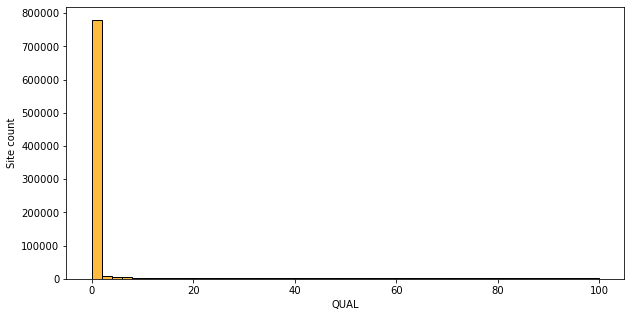

In [463]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
sns.histplot(variants_passGTmiss['QUAL'][variants_passGTmiss['QUAL'] < 100], bins = 50, color = "orange", axes = ax)
ax.set(xlabel='QUAL', ylabel='Site count')
plt.show()

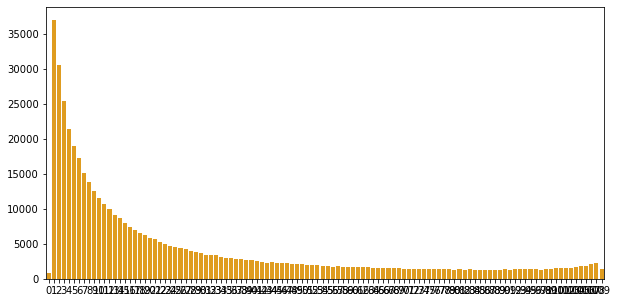

There are 57 invariant sites, 36481 singletons, and 30127 doubletons


In [464]:
gt_array_passQual = gt_array_passGTmiss[Qual_filt]
plot_sfs(gt_array_passQual)

In [465]:
Qual_expr = 'QUAL >= 30'
Qual_filt = variants_passGTmiss.eval(Qual_expr)
Qual_pass = variants_passGTmiss.compress(Qual_filt)

In [466]:
num_sites_keptQual = np.count_nonzero(Qual_filt)
num_sites_filteredQual = np.count_nonzero(~Qual_filt)
print("Removed a total of {0} sites failing Qual filter. {1} sites remaining".format(num_sites_filteredQual, num_sites_keptQual))

Removed a total of 827913 sites failing Qual filter. 472901 sites remaining


### Criteria 3: Allele balance

Allele balance measures the ratio of reads showing the reference allele to all reads. We don't <br>
want sites where there is a skew in the number of reads supporting the REF or the ALT allele

_Filter: AB > 0.25 & AB < 0.75 | AB < 0.01_

**Raw data plot**

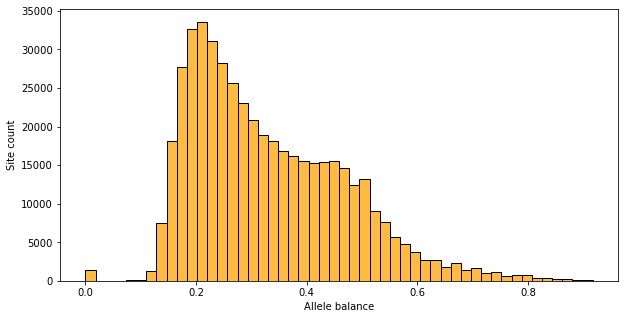

In [467]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
sns.histplot(Qual_pass['AB'], bins = 50, color = "orange", axes = ax)
ax.set(xlabel='Allele balance', ylabel='Site count')
plt.show()

In [468]:
AB_expr = '((AB >= 0.25) & (AB <= 0.75)) | (AB <= 0.01)'
AB_filt = Qual_pass.eval(AB_expr)
AB_pass = Qual_pass.compress(AB_filt)

In [469]:
num_sites_keptAB = np.count_nonzero(AB_filt)
num_sites_filteredAB = np.count_nonzero(~AB_filt)
print("Removed a total of {0} sites failing AB filter. {1} sites remaining".format(num_sites_filteredAB, num_sites_keptAB))

Removed a total of 172396 sites failing AB filter. 300505 sites remaining


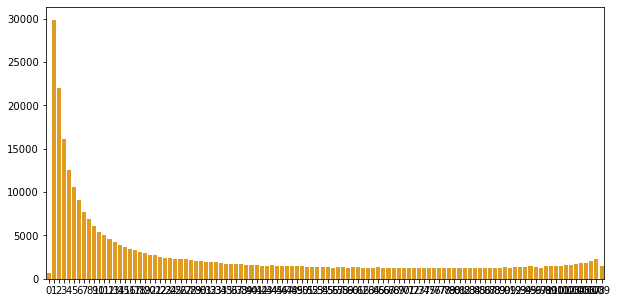

There are 55 invariant sites, 29573 singletons, and 21810 doubletons


In [470]:
gt_array_passAB = gt_array_passQual[AB_filt]
plot_sfs(gt_array_passAB)

### Criteria 4: Strand bias

We want to avoid sites where alleles are only seen on one strand. <br>

Jon Puritz suggests the following filter:

Keep sites that have over 100 times more forward alternate reads than reverse alternate reads and 100 <br>
times more forward reference reads than reverse reference reads along with the reciprocal

_Filter: SAF / SAR > 100 & SRF / SRR > 100 | SAR / SAF > 100 & SRR / SRF > 100_

However, this filter results in the loss of the vast majority of sites (only 737 remain post-filter). <br>
Julia Kreiner saw the same thing in her data. An alternative approach is to keep sites where both the <br>
forward and reverse strand show the ALT allele, as suggested by [Erik Garrison](https://wiki.uiowa.edu/download/attachments/145192256/erik%20garrison%20-%20iowa%20talk%202.pdf?api=v2), the author of `freebayes`. 

_Suggested filter: SAF > 0 & SAR > 0_

**SAF:** Number of reads with ALT allele of forward strand <br>
**SAR:** Number of reads with ALT allele of reverse strand

**Raw data plot**

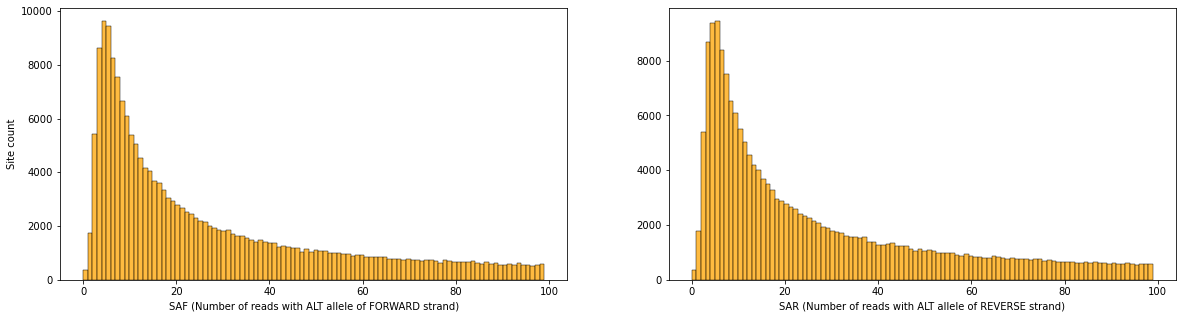

In [471]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(AB_pass['SAF'][AB_pass['SAF'] < 100], bins = 100, color = "orange", ax = ax[0])
ax[0].set(xlabel='SAF (Number of reads with ALT allele of FORWARD strand)', ylabel='Site count')
# plt.show()

sns.histplot(AB_pass['SAR'][AB_pass['SAR'] < 100], bins = 100, color = "orange", ax = ax[1])
ax[1].set(xlabel='SAR (Number of reads with ALT allele of REVERSE strand)', ylabel='')

plt.show()

**Cumulative density plot**

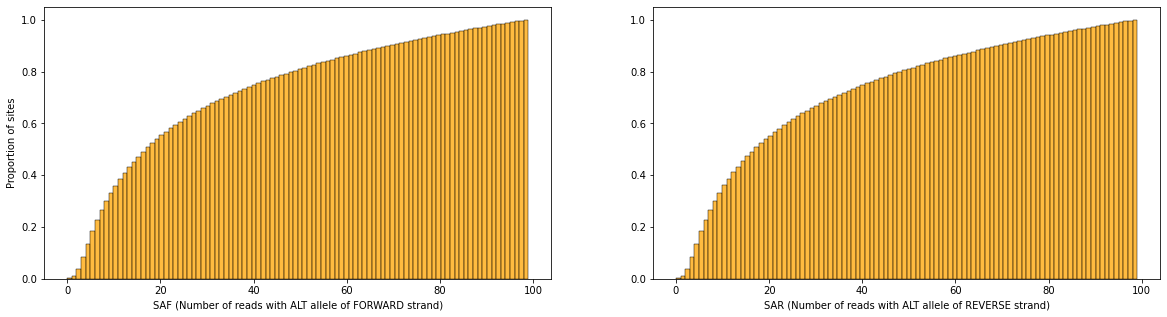

In [472]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(AB_pass['SAF'][AB_pass['SAF'] < 100], cumulative=True, stat='density', bins = 100, color = "orange", ax = ax[0])
ax[0].set(xlabel='SAF (Number of reads with ALT allele of FORWARD strand)', ylabel='Proportion of sites')
# plt.show()

sns.histplot(AB_pass['SAR'][AB_pass['SAR'] < 100], cumulative=True, stat='density', bins = 100, color = "orange", ax = ax[1])
ax[1].set(xlabel='SAR (Number of reads with ALT allele of REVERSE strand)', ylabel='')

plt.show()

In [473]:
SB_expr = '(SAF > 0) & (SAR > 0)'
SB_filt = AB_pass.eval(SB_expr)
SB_pass = AB_pass.compress(SB_filt)

In [474]:
num_sites_keptSB = np.count_nonzero(SB_filt)
num_sites_filteredSB = np.count_nonzero(~SB_filt)
print("Removed a total of {0} sites failing Strand Bias filter. {1} sites remaining".format(num_sites_filteredSB, num_sites_keptSB))

Removed a total of 714 sites failing Strand Bias filter. 299791 sites remaining


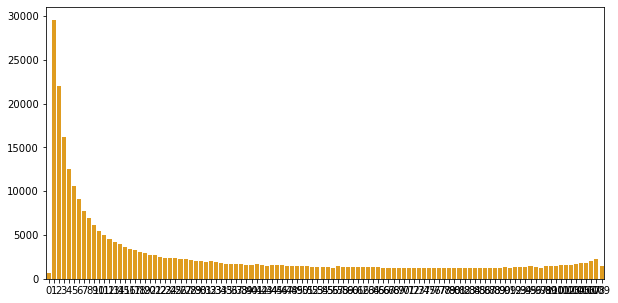

There are 42 invariant sites, 29253 singletons, and 21717 doubletons


In [475]:
gt_array_passSB = gt_array_passAB[SB_filt]
plot_sfs(gt_array_passSB)

### Criteria 5: Mapping quality

We don't want sites where the mapping quality of reads supporting the ALT and REF allele <br>
are very different.

_Original filter: MQM / MQMR > 0.9 & MQM / MQMR < 1.05_

The filter above is the one suggested by Jon Puritz. However, it's not clear to me <br>
why the mapping quality ratios are asymmetrical.

_Suggested filter: MQM / MQMR > 0.9 & MQM / MQMR < 1.10_

_Updated filter:_ MQM >= 30 & MQMR >= 30  (Updated following meeting with Marc and Rob)

**MQM:** Mean Mapping Quality of reads supporting the ALT allele <br>
**MQMR:** Mean Mapping Quality of reads supporting the REF allele

**Raw data plot**

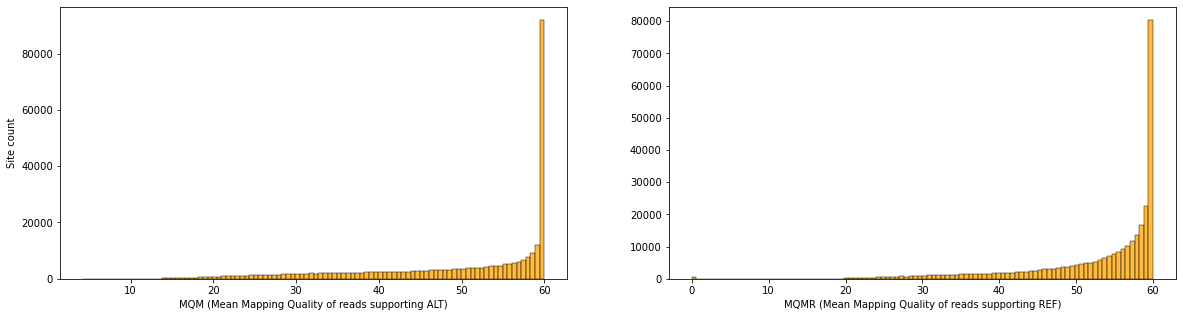

In [476]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(SB_pass['MQM'], bins = 100, color = "orange", ax = ax[0])
ax[0].set(xlabel='MQM (Mean Mapping Quality of reads supporting ALT)', ylabel='Site count')
# plt.show()

sns.histplot(SB_pass['MQMR'], bins = 100, color = "orange", ax = ax[1])
ax[1].set(xlabel='MQMR (Mean Mapping Quality of reads supporting REF)', ylabel='')

plt.show()

**Cumulative density plots**

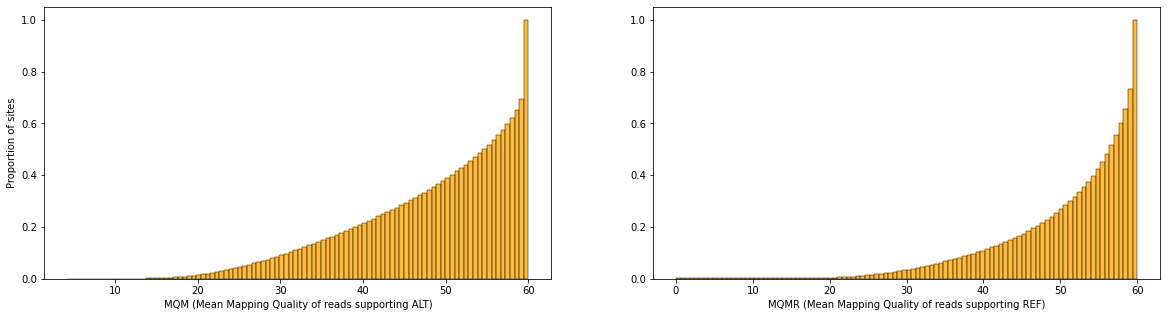

In [477]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(SB_pass['MQM'], bins = 100, cumulative=True, stat='density', color = "orange", ax = ax[0])
ax[0].set(xlabel='MQM (Mean Mapping Quality of reads supporting ALT)', ylabel='Proportion of sites')
# plt.show()

sns.histplot(SB_pass['MQMR'], bins = 100, cumulative=True, stat='density', color = "orange", ax = ax[1])
ax[1].set(xlabel='MQMR (Mean Mapping Quality of reads supporting REF)', ylabel='')

plt.show()

In [478]:
MQ_expr = '(MQM >= 30) & (MQMR >= 30)'
MQ_filt = SB_pass.eval(MQ_expr)
MQ_pass = SB_pass.compress(MQ_filt)

In [479]:
num_sites_keptMQ = np.count_nonzero(MQ_filt)
num_sites_filteredMQ = np.count_nonzero(~MQ_filt)
print("Removed a total of {0} sites failing Mapping Quality filter. {1} sites remaining".format(num_sites_filteredMQ, num_sites_keptMQ))

Removed a total of 29466 sites failing Mapping Quality filter. 270325 sites remaining


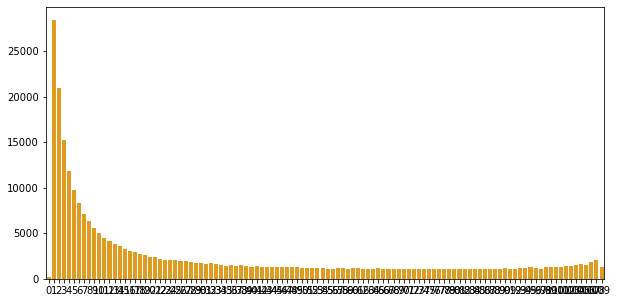

There are 9 invariant sites, 28153 singletons, and 20686 doubletons


In [480]:
gt_array_passMQ = gt_array_passSB[MQ_filt]
plot_sfs(gt_array_passMQ)

### Criteria 6 Paired vs unpaired

Don't want sites where there is a bias in the paired status of reads supporting the ALT <br>
and REF alleles.

_Filter: PAIRED > 0.05 & PAIREDR > 0.05 & PAIREDR / PAIRED < 1.75 & PAIREDR / PAIRED > 0.25 | PAIRED < 0.05 & PAIREDR < 0.05_

**PAIRED:** Proportion of ALT alleles supported by paired reads <br>
**PAIREDR:** Proportion of REF alleles supported by paired reads

**Raw data plot**

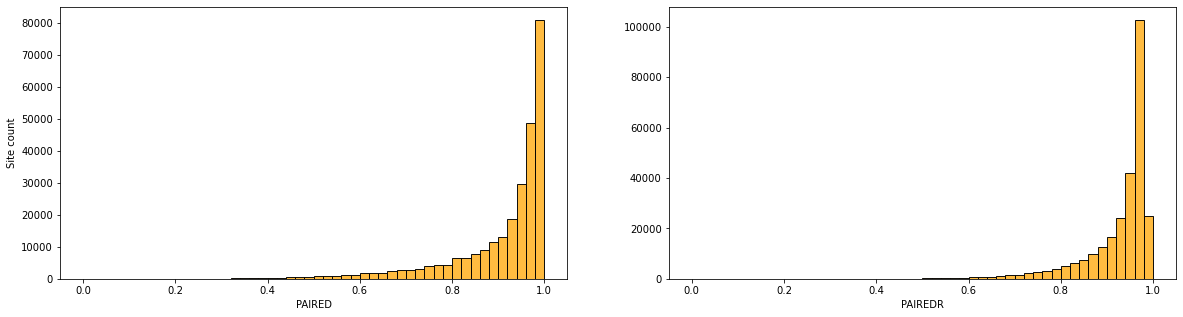

In [481]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(MQ_pass['PAIRED'], bins = 50, color = "orange", ax = ax[0])
ax[0].set(xlabel='PAIRED', ylabel='Site count')
# plt.show()

sns.histplot(MQ_pass['PAIREDR'], bins = 50, color = "orange", ax = ax[1])
ax[1].set(xlabel='PAIREDR', ylabel='')

plt.show()

In [482]:
PR_expr = '((PAIRED > 0.05) & (PAIREDR > 0.05) & (PAIREDR / PAIRED < 1.75 )& (PAIREDR / PAIRED > 0.25)) | ((PAIRED < 0.05) & (PAIREDR < 0.05))'
PR_filt = MQ_pass.eval(PR_expr)
PR_pass = MQ_pass.compress(PR_filt)

<string>:1: RuntimeWarning: divide by zero encountered in true_divide


In [483]:
num_sites_keptPR = np.count_nonzero(PR_filt)
num_sites_filteredPR = np.count_nonzero(~PR_filt)
print("Removed a total of {0} sites failing Pairedness filter. {1} sites remaining".format(num_sites_filteredPR, num_sites_keptPR))

Removed a total of 2885 sites failing Pairedness filter. 267440 sites remaining


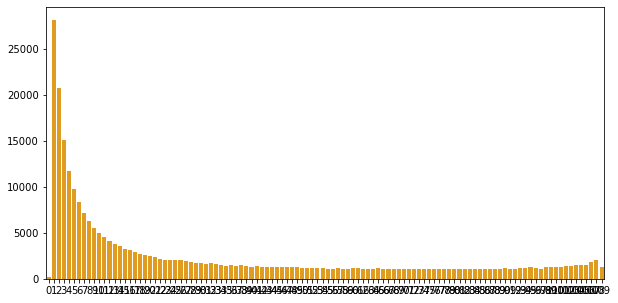

There are 8 invariant sites, 27867 singletons, and 20484 doubletons


In [484]:
gt_array_passPR = gt_array_passMQ[PR_filt]
plot_sfs(gt_array_passPR)

#### Criteria 7: Remove few remaining invariant sites

I think these were generated when splitting `freebayes` haplotype calls using `vcfallelicprimitives`

In [494]:
Inv_expr = '((AF > 0) & (AF < 1))'
Inv_filt = PR_pass.eval(Inv_expr)
Inv_pass = PR_pass.compress(Inv_filt)

In [495]:
num_sites_keptInv = np.count_nonzero(Inv_filt)
num_sites_filteredInv = np.count_nonzero(~Inv_filt)
print("Removed a total of {0} sites failing Pairedness filter. {1} sites remaining".format(num_sites_filteredInv, num_sites_keptInv))

Removed a total of 157 sites failing Pairedness filter. 267283 sites remaining


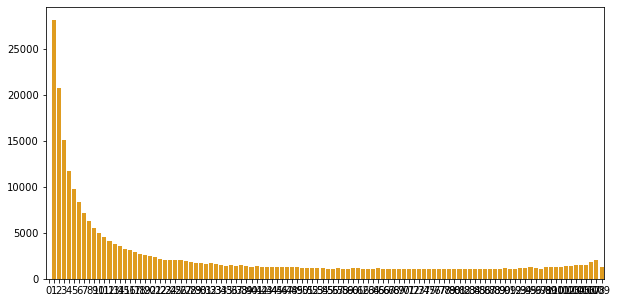

There are 0 invariant sites, 27867 singletons, and 20484 doubletons


In [497]:
gt_array_passInv = gt_array_passPR[Inv_filt]
plot_sfs(gt_array_passInv)

In [501]:
print(f'There are {Inv_pass.n_variants} variants ({round((Inv_pass.n_variants / variants.n_variants) * 100, 2)}%) remaining after filtering.')

There are 267283 variants (5.95%) remaining after filtering.
